In [40]:
import os
import cv2
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import add
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(777)
tf.random.set_seed(777)

In [41]:
BATCH_SIZE = 32
IMG_HEIGHT = 240
IMG_WIDTH = 240
ALPHA = 2e-4


In [42]:
labels = ['PNEUMONIA', 'NORMAL']
def get_data(data_dir, img_width=150, img_height=150):
    """
    Carrega as imagens do diretório especificado, redimensiona e converte em escala de cinza,
    e retorna um array numpy contendo as imagens redimensionadas e seus rótulos numéricos.

    Args:
        data_dir (str): Diretório contendo as pastas 'PNEUMONIA' e 'NORMAL' com as imagens a serem lidas.
        img_width (int): Largura das imagens redimensionadas (padrão: 150).
        img_height (int): Altura das imagens redimensionadas (padrão: 150).

    Returns:
        np.array: Array numpy contendo as imagens redimensionadas e seus rótulos numéricos.
    """
    data = [] 
    exceptions = []
    
    # Loop pelas classes ('PNEUMONIA' e 'NORMAL')
    for i, label in enumerate(labels):
        path = os.path.join(data_dir, label)
        
        # Loop pelas imagens dentro da classe
        for img in os.listdir(path):
            try:
                # Carrega a imagem em escala de cinza e redimensiona
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) 
                resized_arr = cv2.resize(img_arr, (img_width, img_height))
                
                # Adiciona a imagem redimensionada e o rótulo numérico ao array de dados
                data.append([resized_arr, i])
            except Exception as e:
                exceptions.append((os.path.join(path, img), e))
    
    # Imprime a quantidade de imagens lidas e a quantidade de exceções ocorridas
    print(f"Leitura concluída. {len(data)} imagens lidas e {len(exceptions)} exceções.")
    
    return np.array(data)

In [43]:
train = get_data('./archive/chest_xray/train')
test = get_data('./archive/chest_xray/test')
val = get_data('./archive/chest_xray/val')

C:\Users\betin\AppData\Local\Temp\ipykernel_22140\2126597077.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [44]:
from collections import Counter

# Constantes para os rótulos numéricos de cada classe
PNEUMONIA = 1
NORMAL = 0

# Imprime a quantidade de imagens de cada classe no conjunto de treinamento
train_labels = [y for _, y in train]
train_label_counts = Counter(train_labels)

print(f"{train_label_counts[PNEUMONIA]} PNEUMONIA IMAGES IN TRAINING SET")
print(f"{train_label_counts[NORMAL]} NORMAL IMAGES IN TRAINING SET")


1341 PNEUMONIA IMAGES IN TRAINING SET
3875 NORMAL IMAGES IN TRAINING SET


In [45]:
# Imprime o número de imagens em cada conjunto de dados
print(f'Training images: {train.shape[0]}')
print(f'Validation images: {val.shape[0]}')
print(f'Test images: {test.shape[0]}')


Images in TRAINING SET: 5216
Images in VALIDATION SET: 16
Images in TEST SET: 624


In [46]:
train = np.append(train, val, axis=0)
train, val = train_test_split(train, test_size=.20, random_state=777)

In [47]:
def prepare_data(data):
    # Separa as features e os rótulos em duas listas distintas
    x, y = map(list, zip(*data))
    
    # Normaliza as features
    x = (np.array(x) / 255).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
    y = np.array(y)
        
    return x, y

x_train, y_train = prepare_data(train)
x_val, y_val = prepare_data(val)
x_test, y_test = prepare_data(test)

In [48]:
datagen = ImageDataGenerator(
    rotation_range = 20, 
    zoom_range = 0.2, 
    width_shift_range=0.15,  
    height_shift_range=0.15,
    horizontal_flip = False,  
    vertical_flip=False)


datagen.fit(x_train)

In [49]:
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 0.6774036905147297, 1: 1.9092153284671534}


In [50]:
def block(inputs, filters, stride):
    conv_0 = layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(stride, stride), padding='same', activation='relu')(inputs)
    conv_1 = layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(stride, stride), padding='same', activation='relu')(conv_0)
    
    skip = layers.Conv2D(input_shape=input_size, filters=filters, kernel_size=(1, 1), strides=(stride**2, stride**2), padding='same', activation='relu')(inputs)
    
    pool = layers.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(add([conv_1, skip]))
    
    return pool

In [51]:
input_size = (IMG_HEIGHT, IMG_WIDTH, 1)

inputs = tf.keras.Input(shape=input_size, name='input')

y_0 = block(inputs, 16, 2)
y_1 = block(y_0, 32, 1)
y_2 = block(y_1, 48, 1)
y_3 = block(y_2, 64, 1)
y_4 = block(y_3, 80, 1)

gap = layers.GlobalMaxPooling2D()(y_4)
dense = layers.Dense(2, activation='relu')(gap)

outputs = layers.Dense(1, activation='sigmoid')(dense)

In [52]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pneumonia_wnet")
model.summary()

Model: "pneumonia_wnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 120, 120, 16  160         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 60, 60, 16)   2320        ['conv2d_15[0][0]']              
                                                                                     

In [53]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.7, min_delta=ALPHA, patience=7, verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

In [54]:
CALLBACKS = [lr_reduce, early_stopping_cb]

In [55]:
METRICS = ['accuracy',
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')]

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=ALPHA),
    loss='binary_crossentropy', 
    metrics=METRICS
)

In [57]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = BATCH_SIZE),
                    steps_per_epoch=x_train.shape[0]/BATCH_SIZE, 
                    validation_data = (x_val, y_val),
                    validation_steps=x_val.shape[0]/BATCH_SIZE,
                    callbacks = CALLBACKS,
                    class_weight = weights,
                    epochs = 30)

Epoch 1/30
131/130 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.3694 - precision: 0.2696 - recall: 0.8239WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 65s 470ms/step - loss: 0.6892 - accuracy: 0.3694 - precision: 0.2696 - recall: 0.8239 - val_loss: 0.7178 - val_accuracy: 0.2416 - val_precision: 0.2416 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/30
131/130 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7642 - precision: 0.5320 - recall: 0.8266WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 57s 434ms/step - loss: 0.5582 - accuracy: 0.7642 - precision: 0.5320 - recall: 0.8266 - val_loss: 0.5956 - val_accuracy: 0.8997 - val_precision: 0.7242 - val_recall: 0.9447 - lr: 0.0010
Epoch 3/30
131/130 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8650 - precision: 0.6790 - recall: 0.9188WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 56s 429ms/step - loss: 0.4609 - accuracy: 0.8650 - precision: 0.6790 - recall: 0.9188 - val_loss: 0.4928 - val_accuracy: 0.9446 - val_precision: 0.8470 - val_recall: 0.9407 - lr: 0.0010
Epoch 4/30
131/130 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8920 - precision: 0.7357 - recall: 0.9170WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 57s 435ms/step - loss: 0.4065 - accuracy: 0.8920 - precision: 0.7357 - recall: 0.9170 - val_loss: 0.5044 - val_accuracy: 0.9179 - val_precision: 0.7601 - val_recall: 0.9644 - lr: 0.0010
Epoch 5/30
131/130 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.9061 - precision: 0.7723 - recall: 0.9097WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 67s 514ms/step - loss: 0.3822 - accuracy: 0.9061 - precision: 0.7723 - recall: 0.9097 - val_loss: 0.5207 - val_accuracy: 0.8863 - val_precision: 0.6811 - val_recall: 0.9960 - lr: 0.0010
Epoch 6/30
131/130 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.9195 - precision: 0.7976 - recall: 0.9279WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 60s 451ms/step - loss: 0.3479 - accuracy: 0.9195 - precision: 0.7976 - recall: 0.9279 - val_loss: 0.5868 - val_accuracy: 0.8185 - val_precision: 0.5724 - val_recall: 0.9842 - lr: 0.0010
Epoch 7/30
131/130 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.9293 - precision: 0.8273 - recall: 0.9224WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 54s 413ms/step - loss: 0.3221 - accuracy: 0.9293 - precision: 0.8273 - recall: 0.9224 - val_loss: 0.5634 - val_accuracy: 0.8319 - val_precision: 0.5897 - val_recall: 1.0000 - lr: 0.0010
Epoch 8/30
131/130 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9293 - precision: 0.8155 - recall: 0.9434WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 53s 407ms/step - loss: 0.3096 - accuracy: 0.9293 - precision: 0.8155 - recall: 0.9434 - val_loss: 0.3691 - val_accuracy: 0.9379 - val_precision: 0.8052 - val_recall: 0.9802 - lr: 0.0010
Epoch 9/30
131/130 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.9321 - precision: 0.8290 - recall: 0.9334WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 54s 410ms/step - loss: 0.2974 - accuracy: 0.9321 - precision: 0.8290 - recall: 0.9334 - val_loss: 0.3364 - val_accuracy: 0.9456 - val_precision: 0.8356 - val_recall: 0.9644 - lr: 0.0010
Epoch 10/30
131/130 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.9395 - precision: 0.8452 - recall: 0.9416WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 54s 415ms/step - loss: 0.2719 - accuracy: 0.9395 - precision: 0.8452 - recall: 0.9416 - val_loss: 0.3886 - val_accuracy: 0.9160 - val_precision: 0.7434 - val_recall: 0.9960 - lr: 0.0010
Epoch 11/30
131/130 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9369 - precision: 0.8432 - recall: 0.9325WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 59s 449ms/step - loss: 0.2628 - accuracy: 0.9369 - precision: 0.8432 - recall: 0.9325 - val_loss: 0.3325 - val_accuracy: 0.9341 - val_precision: 0.8007 - val_recall: 0.9684 - lr: 0.0010
Epoch 12/30
131/130 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9374 - precision: 0.8441 - recall: 0.9334WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 56s 428ms/step - loss: 0.2588 - accuracy: 0.9374 - precision: 0.8441 - recall: 0.9334 - val_loss: 0.3156 - val_accuracy: 0.9427 - val_precision: 0.8271 - val_recall: 0.9644 - lr: 0.0010
Epoch 13/30
131/130 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9450 - precision: 0.8543 - recall: 0.9526WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 55s 421ms/step - loss: 0.2377 - accuracy: 0.9450 - precision: 0.8543 - recall: 0.9526 - val_loss: 0.3074 - val_accuracy: 0.9370 - val_precision: 0.8006 - val_recall: 0.9842 - lr: 0.0010
Epoch 14/30
131/130 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9405 - precision: 0.8429 - recall: 0.9498WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 71s 542ms/step - loss: 0.2375 - accuracy: 0.9405 - precision: 0.8429 - recall: 0.9498 - val_loss: 0.3690 - val_accuracy: 0.8930 - val_precision: 0.6964 - val_recall: 0.9881 - lr: 0.0010
Epoch 15/30
131/130 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9429 - precision: 0.8538 - recall: 0.9434WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 74s 562ms/step - loss: 0.2241 - accuracy: 0.9429 - precision: 0.8538 - recall: 0.9434 - val_loss: 0.3681 - val_accuracy: 0.9131 - val_precision: 0.7440 - val_recall: 0.9763 - lr: 0.0010
Epoch 16/30
131/130 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9436 - precision: 0.8566 - recall: 0.9425WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 70s 535ms/step - loss: 0.2151 - accuracy: 0.9436 - precision: 0.8566 - recall: 0.9425 - val_loss: 0.2273 - val_accuracy: 0.9561 - val_precision: 0.8657 - val_recall: 0.9684 - lr: 0.0010
Epoch 17/30
131/130 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9477 - precision: 0.8669 - recall: 0.9453WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 70s 537ms/step - loss: 0.2075 - accuracy: 0.9477 - precision: 0.8669 - recall: 0.9453 - val_loss: 0.2507 - val_accuracy: 0.9503 - val_precision: 0.8478 - val_recall: 0.9684 - lr: 0.0010
Epoch 18/30
131/130 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9493 - precision: 0.8765 - recall: 0.9389WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 81s 616ms/step - loss: 0.2060 - accuracy: 0.9493 - precision: 0.8765 - recall: 0.9389 - val_loss: 0.4799 - val_accuracy: 0.8701 - val_precision: 0.6504 - val_recall: 1.0000 - lr: 0.0010
Epoch 19/30
131/130 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9472 - precision: 0.8661 - recall: 0.9443WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 74s 565ms/step - loss: 0.1974 - accuracy: 0.9472 - precision: 0.8661 - recall: 0.9443 - val_loss: 0.2713 - val_accuracy: 0.9360 - val_precision: 0.7943 - val_recall: 0.9921 - lr: 0.0010
Epoch 20/30
131/130 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9527 - precision: 0.8779 - recall: 0.9516WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 76s 581ms/step - loss: 0.1864 - accuracy: 0.9527 - precision: 0.8779 - recall: 0.9516 - val_loss: 0.2533 - val_accuracy: 0.9398 - val_precision: 0.8045 - val_recall: 0.9921 - lr: 0.0010
Epoch 21/30
131/130 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9510 - precision: 0.8747 - recall: 0.9489WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 61s 468ms/step - loss: 0.1869 - accuracy: 0.9510 - precision: 0.8747 - recall: 0.9489 - val_loss: 0.2062 - val_accuracy: 0.9532 - val_precision: 0.8592 - val_recall: 0.9644 - lr: 0.0010
Epoch 22/30
131/130 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9534 - precision: 0.8776 - recall: 0.9553WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 60s 456ms/step - loss: 0.1750 - accuracy: 0.9534 - precision: 0.8776 - recall: 0.9553 - val_loss: 0.3031 - val_accuracy: 0.9169 - val_precision: 0.7470 - val_recall: 0.9921 - lr: 0.0010
Epoch 23/30
131/130 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9505 - precision: 0.8757 - recall: 0.9453WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 65s 498ms/step - loss: 0.1774 - accuracy: 0.9505 - precision: 0.8757 - recall: 0.9453 - val_loss: 0.2319 - val_accuracy: 0.9484 - val_precision: 0.8419 - val_recall: 0.9684 - lr: 0.0010
Epoch 24/30
131/130 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9532 - precision: 0.8763 - recall: 0.9562WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 62s 475ms/step - loss: 0.1702 - accuracy: 0.9532 - precision: 0.8763 - recall: 0.9562 - val_loss: 0.2834 - val_accuracy: 0.9140 - val_precision: 0.7390 - val_recall: 0.9960 - lr: 0.0010
Epoch 25/30
131/130 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9591 - precision: 0.8950 - recall: 0.9562WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 56s 425ms/step - loss: 0.1622 - accuracy: 0.9591 - precision: 0.8950 - recall: 0.9562 - val_loss: 0.1895 - val_accuracy: 0.9580 - val_precision: 0.8828 - val_recall: 0.9526 - lr: 0.0010
Epoch 26/30
131/130 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9568 - precision: 0.8914 - recall: 0.9507WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 57s 434ms/step - loss: 0.1619 - accuracy: 0.9568 - precision: 0.8914 - recall: 0.9507 - val_loss: 0.1667 - val_accuracy: 0.9589 - val_precision: 0.8750 - val_recall: 0.9684 - lr: 0.0010
Epoch 27/30
131/130 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9596 - precision: 0.8958 - recall: 0.9571WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 57s 436ms/step - loss: 0.1532 - accuracy: 0.9596 - precision: 0.8958 - recall: 0.9571 - val_loss: 0.1750 - val_accuracy: 0.9589 - val_precision: 0.8723 - val_recall: 0.9723 - lr: 0.0010
Epoch 28/30
131/130 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9493 - precision: 0.8733 - recall: 0.9434WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 58s 445ms/step - loss: 0.1677 - accuracy: 0.9493 - precision: 0.8733 - recall: 0.9434 - val_loss: 0.2681 - val_accuracy: 0.9255 - val_precision: 0.7760 - val_recall: 0.9723 - lr: 0.0010
Epoch 29/30
131/130 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9546 - precision: 0.8788 - recall: 0.9589WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 56s 426ms/step - loss: 0.1554 - accuracy: 0.9546 - precision: 0.8788 - recall: 0.9589 - val_loss: 0.2086 - val_accuracy: 0.9456 - val_precision: 0.8203 - val_recall: 0.9921 - lr: 0.0010
Epoch 30/30
131/130 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9632 - precision: 0.8998 - recall: 0.9672WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr


130/130 [==============================] - 58s 440ms/step - loss: 0.1379 - accuracy: 0.9632 - precision: 0.8998 - recall: 0.9672 - val_loss: 0.4386 - val_accuracy: 0.9035 - val_precision: 0.7147 - val_recall: 1.0000 - lr: 0.0010


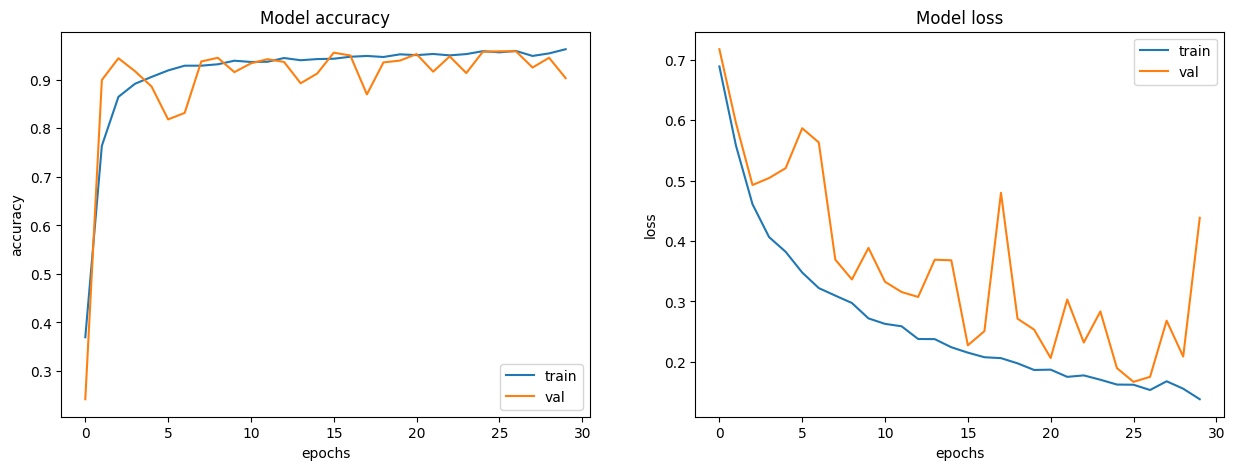

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [62]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 77ms/step - loss: 0.3371 - accuracy: 0.8958 - precision: 0.8314 - recall: 0.9060
Loss of the model is -  0.33708006143569946
20/20 [==============================] - 1s 72ms/step - loss: 0.3371 - accuracy: 0.8958 - precision: 0.8314 - recall: 0.9060
Accuracy of the model is -  89.58333134651184 %


In [63]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

20/20 [==============================] - 2s 79ms/step
